In [3]:
#bloque de imports (bibliotecas de funciones)
# os nos proporciona herramientas para manejo de ficheros y directorios
import os
from os import scandir, getcwd
from os.path import abspath

#libreria para leer los ficheros de tipo edt donde se almacenan los electroencefalogramas 
import pyedflib
import csv, operator
#nuestras amigas numpy, si queremos usar panda pos habra que añadirlas
import numpy as np
import pandas as pd

#sklearn una de las bibliotecas mas utilizadas para programacion ML
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix

#para dibujar
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#bloque de funciones 
# las funciones son bloques de codigos que se repiten frecuentemente
# para evitar repetir el codigo o simplemente por hacerlo mas legible creamos estos fragmentos de codigo  

#definimos funciona para mostrar los resultados
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

def lsAb(ruta = getcwd()):
	return [abspath(arch.path) for arch in scandir(ruta) if arch.is_file()]

def ls(ruta = getcwd()):
	return [arch.name for arch in scandir(ruta) if arch.is_file()]

# funcion que usamos en las primeras versiones donde lo que hacemos es coger todo el listado de impulsos y meterlos en un array
# si usaramos metodos mas propios de DL hubiera podido ser mas efectivo
def insertar(ruta,etiqueta,canales):
        files=lsAb(ruta)
        numeroDeRecords=2500
        numeroDeCanales=len(canales)
        inicio=0
        retorno = []
        contador=0
        ant=0
        dir=0  
        a=[]
        for file in files:
            miEDFReader = pyedflib.EdfReader(file)
            for canal in canales:
                if len(a)==0:
                    a=miEDFReader.readSignal(canal,inicio,numeroDeRecords+inicio)
                else:
                    a=a+miEDFReader.readSignal(canal,inicio,numeroDeRecords+inicio)
            miEDFReader.close
            retorno.append(a)
            a=[]
        return retorno
# ML no esta pensado para encontrar patrones ocultos asi que hemos hecho un poco de "data science" sin tener conocimientos de neurologia
# y se nos ha ocurrido que podria ser relevante las siguientes features:
# el pico mas alto de tension
# velocidad de subida del mas alto
# pico mas bajo
# velocidad con el que bajo
# media del canal
# media de todos los canales
# con tiempo tendriamos que probar otras features, un rasgo que posiblemente ayudaria es el sexo, que en los ficheros que estamos
# usando no los tienen marcado y habria que añadirlo manualmente.

def sacandodatos(ruta,etiqueta,numeroCanales):
        files=lsAb(ruta)
        numeroDeRecords=2500
        numeroDeCanales=16
        inicio=0
        retorno = []
        media=0
        ant=0
        contador=0
        media = 0
        anterior = 0
        dir = 0
        sexo=1
        numeroFicheros=len(files)
        stop=0
        for file in files:
            miEDFReader = pyedflib.EdfReader(file)
            signal_labels = miEDFReader.getSignalLabels()
            
            datos=[contador]
            contador+=1
            mediatotal=0
            canal=-1
            while canal<numeroDeCanales-1:
                canal+=1
                maximos = 0
                minimos = 0
                baseMax = 1
                baseMin = 1
                baseactual=1
                media = 0
                anterior = 0
                dir = -1
                lineas=-1
                while lineas<numeroDeRecords:
                        lineas+=1
                        a=miEDFReader.readSignal(canal,lineas+inicio,1)
                        media=a+media
                        if anterior<a and dir>0:
                            baseactual+=1
                        elif anterior>a and dir<0:
                            baseactual+=1
                        else:
                            baseactual=0
                            dir=-dir
                        if maximos<a:
                            maximos=a
                            baseMax=baseactual
                        if minimos>a:
                            minimos=a
                            baseMin=baseactual
                media=media/numeroDeRecords
                mediatotal+=media
                #datos.append(signal_labels[canal])
                datos.append(float(maximos))
                datos.append(float(minimos))
                datos.append(float(baseMax))
                datos.append(float(baseMin))
                datos.append(float(media))
            mediatotal=float(mediatotal/numeroDeCanales)
            datos.append(mediatotal)
            retorno.append(datos)            
            miEDFReader.close
        return retorno
    
#herramienta para contar cuantos ficheros tiene un directorio
def contarfiles(ruta):
    files=lsAb(ruta)
    contador=0
    for file in files:
        contador+=1
    return(contador)


In [5]:




ficherosNoEpi="D:/IA/#1 - Cleaning _ Exploratory data Pandas/orgia/inputs/Raw/noepi"
ficherosEpi="D:/IA/#1 - Cleaning _ Exploratory data Pandas/orgia/inputs/Raw/epi"
ficherosNoEpiTest="D:/IA/#1 - Cleaning _ Exploratory data Pandas/orgia/inputs/Raw/noepiTest"
ficherosEpiTest="D:/IA/#1 - Cleaning _ Exploratory data Pandas/orgia/inputs/Raw/epiTest"
LABELS = ["Epilepticos","no epilepticos"]
MasterTable = []
Etiqueta = []
temp = []

a=contarfiles(ficherosNoEpiTest)
b=contarfiles(ficherosEpiTest)
contadorTests= a+b

canales =[0]

cvssalida=open('salida.csv','w',newline='')
salida=csv.writer(cvssalida,delimiter=';') 

# leyendo los ficheros de datos , y por auditar el proceso creamos ficheros salida.csv para poder revisar que ha estado haciendo
cvsetiquetas=open('etiqueta.csv','w')
#for line in insertar(ficherosNoEpi,"noepi",canales):
#    print(line)
#print("sacandodatos")

for line in sacandodatos(ficherosNoEpi,"noepi",canales):
    Etiqueta.append("noepi")
    MasterTable.append(line)
    cvsetiquetas.writelines(['noepi;'])
    salida.writerow(line)
    
#for line in insertar(ficherosEpi,"epi",canales):
for line in sacandodatos(ficherosEpi,"epi",canales):
    Etiqueta.append("epi")
    MasterTable.append(line)
    cvsetiquetas.writelines(['epi;'])
    salida.writerow(line)
##for line in insertar(ficherosEpiTest,"epi",canales):
for line in sacandodatos(ficherosEpiTest,"epi",canales):
    Etiqueta.append("epi")
    MasterTable.append(line)
    cvsetiquetas.writelines(['epi;'])
    salida.writerow(line)
#for line in insertar(ficherosNoEpiTest,"noepi",canales):
for line in sacandodatos(ficherosNoEpiTest,"epi",canales):
    MasterTable.append(line)
    Etiqueta.append("noepi")
    cvsetiquetas.writelines(['noepi;'])
    salida.writerow(line)
del salida
cvssalida.close()
cvsetiquetas.flush()
cvsetiquetas.close()

0.9606299212598425 0.75


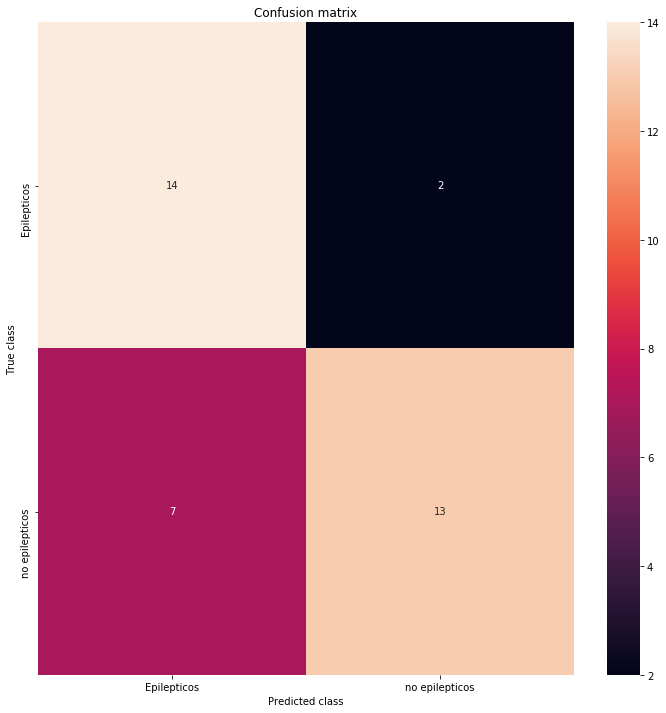

[[14  2]
 [ 7 13]]
0


In [27]:
#ahora viene el trabajo de IA

MasterTablePanda = pd.DataFrame(MasterTable)
df = (MasterTablePanda-MasterTablePanda.min())/(MasterTablePanda.max()-MasterTablePanda.min())

EtiquetaPD=pd.DataFrame(Etiqueta)
##print(EtiquetaPD)

def split_vals(a,n): return a[:n].copy(), a[n:].copy()
i=0
b=0
##PCA para disminuir número de columnas
##Si hacemos esto requiere separar previamente la columa final de EPI/NO EPI,
##para asegurarnos de que no la cambie
RANDOM_STATE=17
X=df
y=Etiqueta
pca= PCA(n_components=0.9999998,random_state=RANDOM_STATE).fit(X)
X_pca=pca.transform(X)
X_pca.shape
##debe de se [array([])]
#print ("done")
##Random Forest splitting the data

n_valid = contadorTests
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df, n_trn)
#X_train, X_valid = split_vals(X_pca, n_trn)
X_train, X_valid = split_vals(X, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, X_valid.shape, n_valid
# se muestra la media de realizar 32 veces el proceso, dos veces donde hemos ido probando disntintas combinaciones
#aqui hay mucho mas juego pero con las features que tenemos aun tenemos un % muy bajo
#m = RandomForestClassifier(n_estimators=6, min_samples_leaf=6, max_features=48, n_jobs=-1)  #0.6319444444444444 - 0.6501736111111112
#m = RandomForestClassifier(n_estimators=7, min_samples_leaf=6, max_features=48, n_jobs=-1)  #0.6397569444444441 - 0.6137152777777777
#m = RandomForestClassifier(n_estimators=12, min_samples_leaf=6, max_features=48, n_jobs=-1) #0.6484375 -0.6354166666666665
#m = RandomForestClassifier(n_estimators=6, min_samples_leaf=12, max_features=48, n_jobs=-1)  #0.6302083333333331 0.6354166666666667
#m = RandomForestClassifier(n_estimators=7, min_samples_leaf=12, max_features=48, n_jobs=-1)  #0.6267361111111113 0.6406250000000001
#m = RandomForestClassifier(n_estimators=12, min_samples_leaf=12, max_features=48, n_jobs=-1) #0.625 0.6215277777777778
#m = RandomForestClassifier(n_estimators=6, min_samples_leaf=6, max_features=24, n_jobs=-1)  #0.626736111111111-0.631076388888889
#m = RandomForestClassifier(n_estimators=7, min_samples_leaf=6, max_features=24, n_jobs=-1)  #0.631076388888889 0.6302083333333333
#m = RandomForestClassifier(n_estimators=12, min_samples_leaf=6, max_features=24, n_jobs=-1) #0.6215277777777778 0.6180555555555554

m = RandomForestClassifier(n_estimators=6, min_samples_leaf=6, max_features=48, n_jobs=-1)
#ejecutandolo 1000 veces la media de exito ha sido 66,6666666% con valores minimo del 50% y el 85%
#con mas casos y buscando otras features es posible elevar el porcentaje
m.fit(X_train, y_train) #trains the RF with our data
trainscore = m.score(X_train, y_train)
predscore = m.score(X_valid, y_valid)
print(trainscore,predscore) #-> prints the accuracy of the model in training and testing
conf_matrix=confusion_matrix(y_valid, m.predict(X_valid))
#b+=predscore/12
mostrar_resultados(y_valid, m.predict(X_valid))
print(conf_matrix)
#i+=1
print (b)